<img src="attachment:webscraping.png" width="200">

# Introduction to Web Scraping in Python

November 12, 2020 11-12:30 PM Zoom

Supported by DS2F "Digital Scholarship & Data Science" Fellowship, University of Arizona Libraries

Instructor: Sabrina Nardin, Sociology Ph.D. Candidate

## Getting Started

To participate in this workshop, you only need a computer and an internet connection. I suggest using a relatively up-do-date version of a browser like Chrome, Firefox, or Safari. If after the workshop you want to save this Jupyter notebook on your computer, go under File > Download as > select your preferred format. You can also find a version of this workshop here: https://github.com/brinasab/web_scraping

Let's run some code in Jupyter:

In [350]:
# print out a welcome message (to execute this code click "Run" at the top of the screen or press Ctrl+Enter)
print("Welcome!")

Welcome!


Other useful things to keep in mind:
* It might happen that you get disconnected from this vitual environment ("Connection failed" message). To reconnect, simply open again the link I provided in the Zoom chat. Once the environment is rebuilt, make sure to re-run the code you had before the disconnection
* Please note that if, after the workshop, you load again this notebook using the link I provided, the changes you do on the code won't be saved on the virtual environemtn. If you want to play around with it, just make sure to download and save the notebook on your laptop

## Learning Objectives

By the end of this workshop you will be able to...
* Read an html page and evaluate it (by identifying and deciding which tags to use)
* Use the library “requests” to interact with servers
* Use the library “beautiful soup” to parse and scrape data
* Understand some of the key tasks in static web scraping: errors, missing data, turn pages
* Conceptualize web scraping as a process that goes from the website to the cleaned data

## What is Web Scraping?

* Web scraping is the process of gathering or "scraping" information from a website
* If you have ever copied and pasted information from the Internet, you have performed the same task of any web scraper, just on a small scale. Web scraping allows to automate this process to collect hundreds, thousands, or millions of information
* It pertains to the data collection phase of a project, and usually targets structured data: for example companies' names, emails, phones, newspaper articles, reviews, prices, etc.

There are mainly two ways to get data from a website (with Python, R, etc.):
1. Using the API, Application Programming Interface, provided by the website. This option is always preferable if an API is available, for example Facebook, Twitter, YouTube, etc. all have their own APIs
2. Directly accessing the HTML of the website: we focus on this in this workshop

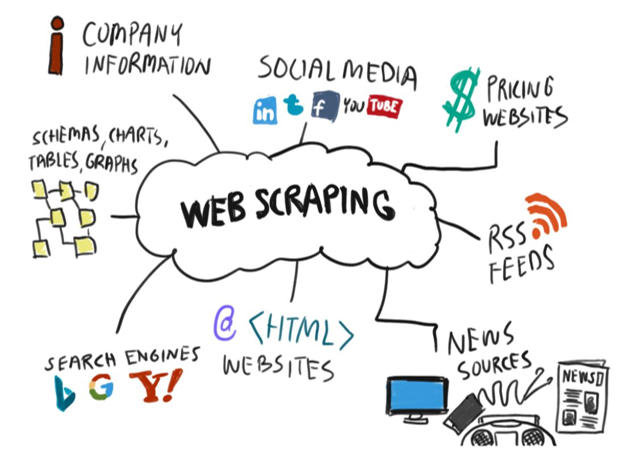

## Ethics of Scraping... just because you can, does not mean you should

1. Private data (not OK!) VS. Public data (OK!). If there is a password or other barriers put in place by the host site, then it is likey private data


2. Check the “robots.txt” file before you scrape a website, by adding /robots.txt at the end of your url
    - Example NYT Robot File: https://www.nytimes.com/robots.txt (the star in the User Age stays for "all robots")
    - Further info: https://www.robotstxt.org/robotstxt.html
    
                                                         
3. Read the website’s Terms of Service (ToS): these are the legal rules you agree to observe in order to use a service. Some people follow it, others do not


4. If the website has an API, use it
    - Example on how to use API to scrape NYT news: https://martinheinz.dev/blog/31
    - Further info on news media APIs: https://en.wikipedia.org/wiki/List_of_news_media_APIs
                                                                   

5. Take a look at the "hiQ Labs v. LinkedIn" lawsuit case
https://www.abajournal.com/lawscribbler/article/scraping-a-public-website-isnt-a-crime


6. Some things to keep in mind while you scrape to avoid being banned:
    - be slow: webscraping consumes server resources from the website you are scraping, make sure to use a conservative rate when making requests to a server (e.g. 1 request every 10 seconds or set a random number)
    - save and store the content of what you scrape, so to avoid scraping it again if you need it in the future
    - be identifiable: identify your scraper with a "user agent string" that allows to identify your client browser information
    - example code: <code>user = { "User-Agent" : "News extractor for research project, email: youremail@gmail.com" } 
    response = requests.get("put here the url you want to scrape", user)
    time.sleep(10)</code>

## Getting and Parsing Web Data: Requests and Beautiful Soup

In [5]:
# install packages we need for the workshop 
# nothing to edit here, but it’s important to make sure we run this block

import requests 
from bs4 import BeautifulSoup
from requests.exceptions import HTTPError
import time
import random
import re
import pandas as pd
import numpy as np

print("All packages available and imported!")

All packages available and imported!


Requests and Beautiful Soup are the two main webscraping libraries we need for this tutorial: 

* <b>Requests</b>: to get the data. It sends HTTP requests to web servers and allows us to access the response
* <b>Beautiful Soup (bs4)</b>: to parse the data. It allows to navigate and extract data from the html and other markup languages. Basically, it helps navigating the html tree by parsing it and to extract the desired tags

NB: Encoding (i.e. transforming bytes into characters we can read), is an important thing in webscraping. We won't go into detail, just remember that when the library "requests" gets the data, it encodes them for you, by making an educated guess. The most common encoding is UTF-8 which is good for English and most languages, but not all

Let's make a requests and parse the response with Beautiful Soup and see what happens:

In [354]:
# make a requests to the arizona web server
# get the html data that the server sends back and store the response in our "response" variable

url = "https://linguistics.arizona.edu/peo-faculty"
response = requests.get(url)
print(type(response))

<class 'requests.models.Response'>


In [355]:
# check our response: status code (2xx means good, 4xx or 5xx mean errors) and our encoding

print("Response code is:", response.status_code)
print("Encoding is:", response.encoding)

Response code is: 200
Encoding is: utf-8


In [356]:
# it is possible to change the encoding, requests will use the new value whenever you call .text
# for ex. here we changed to latin-1 and back to utf-8

response.encoding = 'ISO-8859-1'  # latin-1
response.encoding = 'utf-8'

In [358]:
# you can specify your User-Agent as you make the http request
# as ethical scrapers, we use it to make our intentions clear and provide a way to be contacted 

headers = { "User-Agent" : "web scraper for classroom purpose (snardin@email.arizona.edu)" } 
response = requests.get(url, params = headers)

Making requests to web server:

* Computers talk to each other by making and receiving <b>data requests</b>: when you click on a page, your web browser makes a request (what we did above with the "requests.get") to the web server of that page and gets back a response object. For example, if you type https://sociology.arizona.edu/news into your <b>web browser</b>, you are telling the arizona <b>web server</b> that you would like to visualize the information stored at /news. The arizona web server receives your request and sends back to your web browser a reponse, i.e. a bunch of files that your browser transforms into a nice visual display that might include texts, graphics, hyperlinks, etc.


* A <b>User-Agent</b> is a text string that you web browser sends evey time you make a requests to a website, and communicates info about your device type, operating system, and browser. This info is useful for the server as it prepares its response accordingly. For us, this is important because you can have your scraper being blocked and many websites do not let you view the content if the User-Agent is not set. To know what is your User-Agent, you can just type "what is my user agent" in the Google search bar. This is how a Chrome User-Agent on Windows looks like:

    <code>user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.183 Safari/537.36"</code>
    
    
* Nice website for additional information: https://towardsdatascience.com/ethics-in-web-scraping-b96b18136f01

In [479]:
# we can not access and parse our response by just printing it
# we will use Beautiful Soup (bs) to parse the response, but we first need to access its content

# we can do it using the text property (str)
response_txt = response.text
print("response.text gives us:", type(response_txt))

response.text gives us: <class 'str'>


In [480]:
# create a bs object, store it in the variable 'soup', and parse it using the html parser

soup = BeautifulSoup(response_txt, "html")
print(type(soup))

<class 'bs4.BeautifulSoup'>


In [361]:
# use bs prettify() method to print out the html content nicely formatted as tree

print(soup.prettify())

<!DOCTYPE html>
<!--[if lt IE 7]><html class="lt-ie9 lt-ie8 lt-ie7" lang="en" dir="ltr"><![endif]-->
<!--[if IE 7]><html class="lt-ie9 lt-ie8" lang="en" dir="ltr"><![endif]-->
<!--[if IE 8]><html class="lt-ie9" lang="en" dir="ltr"><![endif]-->
<!--[if gt IE 8]><!-->
<html dir="ltr" lang="en">
 <!--<![endif]-->
 <head>
  <meta charset="utf-8"/>
  <meta content="Drupal 7 (http://drupal.org)" name="Generator"/>
  <link href="https://linguistics.arizona.edu/sites/linguistics.arizona.edu/files/favicon_11.ico" rel="shortcut icon" type="image/vnd.microsoft.icon"/>
  <meta content="width=device-width, initial-scale=1.0, user-scalable=yes" name="viewport"/>
  <meta content="width" name="MobileOptimized"/>
  <meta content="true" name="HandheldFriendly"/>
  <meta content="yes" name="apple-mobile-web-app-capable"/>
  <title>
   Faculty Members | The Department of Linguistics
  </title>
  <link href="https://linguistics.arizona.edu/sites/linguistics.arizona.edu/files/css/css_xE-rWrJf-fncB6ztZfd2hux

## What is this mess? It is the HTML of our Webpage!

Let's go back to our webpage and inspect it using our web broweser development tools: https://linguistics.arizona.edu/peo-faculty

Go to the website, right click on it, and select the "inspect" option. I will do it using my own web broswer (Chrome), you can follow along but might be different for you. In Chrome or Firefox, there is a small box with an arrow icon. In Safari, I *think* there should be a button to the left of the search bar, which looks like a small target.

Usually a website is made of the following:

* <b>HTML</b> the core element of a website, basically one or more text files written in HTML or Hypertext Markup Language, which is not a programming language, like Python, but is a so-called "markup language" it uses a set of rules or tags to  organanize the webpage (i.e. makes the text bold, creates body text, paragraphs, inserts hyperlinks, etc.), but when the page is displayed the markup language is hidden
* <b>CSS</b> which means Cascading Style Sheets, basically it adds styling to make the page looks nicer 
* <b>JS</b> Javascript code is used to add interactivity to the page (and you need "dynamic webscraping" to interact with it)
* <b>Images</b> for example jpg and png allow webpages to show pictures, other common stuff are videos or multimedia

### *tags*
* direct formatting vs logical formatting
* tags follow a tree-like structure and are nested 
* tags go in pairs: one on each end of the content that they include, the first is the start tag, the second is the end tag 
* list of tags: https://developer.mozilla.org/en-US/docs/Web/HTML/Element

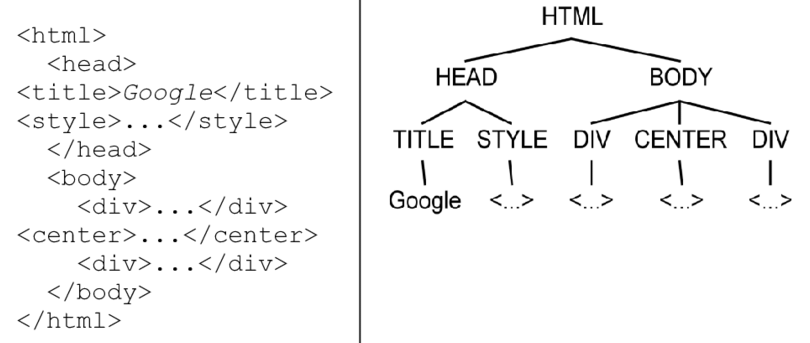

### *class and id attributes*
* class and id are special attributes that specify more information about a given html tag, usually a certain style
* are optional in that not all tags have them, but they can be used to all of them
* the same class can be shared between elements but each element can only have one id

In web scraping, class and attributes are important because we can extract elemenets using class or id attributes. Since they offer quite detailed information, they help to find the specific element we want to scrape.

## Common Beautiful Soup methods:

In [362]:
# get_text() extracts all text 

print(soup.get_text())










Faculty Members | The Department of Linguistics































<!--//--><![CDATA[//><!--
(function(i,s,o,g,r,a,m){i["GoogleAnalyticsObject"]=r;i[r]=i[r]||function(){(i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)})(window,document,"script","https://www.google-analytics.com/analytics.js","ga");ga("create", "UA-28443740-18", {"cookieDomain":"auto"});ga("send", "pageview");
//--><!]]>


<!--//--><![CDATA[//><!--
jQuery.extend(Drupal.settings, {"basePath":"\/","pathPrefix":"","ajaxPageState":{"theme":"unitblue","theme_token":"3k0hsz5D6ALBfXL_Qy8Qi3nlCZvd89Z1V4nXAZ7DgiQ","jquery_version":"1.7","js":{"sites\/all\/modules\/jquery_update\/replace\/jquery\/1.7\/jquery.min.js":1,"misc\/jquery-extend-3.4.0.js":1,"misc\/jquery.once.js":1,"misc\/drupal.js":1,"sites\/all\/modules\/jquery_update\/replace\/ui\/ui\/minified\/jquery.ui.effect.min.js":1,"sites\/all\/modul

In [363]:
# find() returns the FIRST instance of a tag (eg. p, table, td, img, title, etc.)
# here we ask for the first paragraph tag

print(soup.find('p'))

<p>Until further notice, the University of Arizona, in accordance with the guidelines recommended by the <strong><a href="https://slack-redir.net/link?url=https%3A%2F%2Fwww.cdc.gov%2Fcoronavirus%2F2019-ncov%2Fcommunity%2Findex.html%3FCDC_AA_refVal%3Dhttps%253A%252F%252Fwww.cdc.gov%252Fcoronavirus%252F2019-ncov%252Fpreparing-individuals-communities.html&amp;v=3" rel="noreferrer noopener" target="_blank">Centers for Disease Control and Prevention</a></strong>, encourages all employees to work remotely. Our offices are closed to the public, but you can reach us Monday–Friday 8:30am-4pm.</p>


In [364]:
# we can extract only the text from our paragraph tag, using the get_text() function 

first_paragraph = soup.find('p').get_text() 
print(first_paragraph)

# note that .text also does the same thing, it is just a property calling get_text()
#print(soup.find('p').text) 

Until further notice, the University of Arizona, in accordance with the guidelines recommended by the Centers for Disease Control and Prevention, encourages all employees to work remotely. Our offices are closed to the public, but you can reach us Monday–Friday 8:30am-4pm.


In [365]:
# find_all() returns all instances of a tag on a given page

print(soup.find_all('p'))

[<p>Until further notice, the University of Arizona, in accordance with the guidelines recommended by the <strong><a href="https://slack-redir.net/link?url=https%3A%2F%2Fwww.cdc.gov%2Fcoronavirus%2F2019-ncov%2Fcommunity%2Findex.html%3FCDC_AA_refVal%3Dhttps%253A%252F%252Fwww.cdc.gov%252Fcoronavirus%252F2019-ncov%252Fpreparing-individuals-communities.html&amp;v=3" rel="noreferrer noopener" target="_blank">Centers for Disease Control and Prevention</a></strong>, encourages all employees to work remotely. Our offices are closed to the public, but you can reach us Monday–Friday 8:30am-4pm.</p>, <p>For current linguistics majors/minors and prospective students who need advising, please contact:</p>, <p>For all other inquiries, please contact:</p>, <p>Get <strong><a href="https://www.arizona.edu/coronavirus-covid-19-information" rel="noreferrer noopener" target="_blank">COVID-19 updates and information</a> </strong>for the University of Arizona community. Also, see <strong><a href="https://sb

In [366]:
# we might be tempted to extract the text from each of these p using the same syntax we used with find() but... 
# NOTE: LEAVE THIS EMPTY AND CODE IT INTERACTIVELY

all_paragraphs = soup.find_all('p').get_text() 
print(all_paragraphs)

AttributeError: ResultSet object has no attribute 'get_text'. You're probably treating a list of items like a single item. Did you call find_all() when you meant to call find()?

In [371]:
# to get all paragraphs text, we need to loop over instead
# NOTE: LEAVE THIS EMPTY AND CODE IT INTERACTIVELY

all_paragraphs = soup.find_all('p')

for paragraph in all_paragraphs:
    print(paragraph.get_text(), "\n")

Until further notice, the University of Arizona, in accordance with the guidelines recommended by the Centers for Disease Control and Prevention, encourages all employees to work remotely. Our offices are closed to the public, but you can reach us Monday–Friday 8:30am-4pm.
For current linguistics majors/minors and prospective students who need advising, please contact:
For all other inquiries, please contact:
Get COVID-19 updates and information for the University of Arizona community. Also, see SBS resources for continuing instruction and learning.
    
Copyright © 2017 Board of Regents | The University of Arizona | All Rights Reserved | Website Project by SBS TechDepartment of Linguistics • Communication Bldg. Room 109 • Tucson, AZ 85721 • TEL 520-621-6897 • FAX 520-626-9014


In [372]:
# we can also save them into a new list

all_paragraphs_txt = []

for paragraph in all_paragraphs:
    paragraph_txt = paragraph.get_text()
    all_paragraphs_txt.append(paragraph_txt)
    
print(all_paragraphs_txt)

#paragraph_txt = paragraph_txt.replace('\xa0',' ')

# print those separatly from list and check

['Until further notice, the University of Arizona, in accordance with the guidelines recommended by the\xa0Centers for Disease Control and Prevention,\xa0encourages all employees to work remotely. Our offices are closed to the public, but you can reach us Monday–Friday 8:30am-4pm.', 'For current linguistics majors/minors and prospective students who need advising, please contact:', 'For all other inquiries, please contact:', 'Get\xa0COVID-19 updates and information\xa0for the University of Arizona community. Also, see\xa0SBS resources\xa0for continuing instruction and learning.', '    ', 'Copyright © 2017 Board of Regents | The University of Arizona | All Rights Reserved | Website Project by SBS TechDepartment of Linguistics • Communication Bldg. Room 109 • Tucson, AZ 85721 • TEL 520-621-6897 • FAX 520-626-9014']


In [369]:
# find_all() by default give us all tags of the kind we ask for
# but we can use it also just to get only the first tag, we just need to specify it

all_paragraphs = soup.find_all('p')[0].get_text()
print(all_paragraphs)

Until further notice, the University of Arizona, in accordance with the guidelines recommended by the Centers for Disease Control and Prevention, encourages all employees to work remotely. Our offices are closed to the public, but you can reach us Monday–Friday 8:30am-4pm.


In [ ]:
# NOTE: SKIP THIS?
# we can pass arguments in find() and in find_all()
# show them tags

# here we use find_all() to get all instances of a td tag (cells of a table)
print(soup.find_all('td'))

# but we get also ask for all instances of an exact match
print(soup.find_all('td', attrs = {'class' : 'views-field views-field-realname'}))

# anther syntax style to add arguments
#print(soup.find_all('td', class_="views-field views-field-realname")

## Example 1: extract all names, emails, phone numbers from one page

For this example, we use the same website as above <code>https://linguistics.arizona.edu/peo-faculty</code> We have already made a request with "requests" and parsed it with "beautiful soup." Our first taks is to collect the names of the faculty. We start by using the browser develompent tools (directly on the webpage) to check the tags that hold the names: right click on the website and select the "inspect" option. 

In [373]:
# this is the html syntax we see on the website: <td class="views-field views-field-realname">
# "td" is the tag for tables, the class specifies further info about the tag

for row in soup.find_all('td',  attrs = {'class': 'views-field views-field-realname'}): 
    print(row.prettify())

<td class="views-field views-field-realname">
 <a href="/user/diana-archangeli">
  Diana Archangeli
 </a>
 <br/>
 Professor, Director of Graduate Studies
 <br/>
 <strong>
  Email:
 </strong>
 <a href="mailto:dba@email.arizona.edu">
  dba@email.arizona.edu
 </a>
 <br/>
 <strong>
  TEL:
 </strong>
 (520) 621-2184
 <br/>
 <strong>
  Office:
 </strong>
 Douglass 228
 <br/>
 Archangeli’s research explores both the fundamental concepts of how phonological systems are organized and the concrete ways in which sounds are used and produced in language.
Her conceptual research, Emergent Phonology (or Minimalist Phonology), asks the question of how much does phonological...
 <br/>
 <a href="/user/diana-archangeli">
  [more information]
 </a>
</td>

<td class="views-field views-field-realname">
 <a href="/user/andy-barss">
  Andy Barss
 </a>
 <br/>
 Associate Professor, Emeritus
 <br/>
 <strong>
  Email:
 </strong>
 <a href="mailto:barss@email.arizona.edu">
  barss@email.arizona.edu
 </a>
 <br/>
 <

In [374]:
# get all names
# there is some messiness here not properly logical

for row in soup.find_all('td', attrs = {'class': 'views-field views-field-realname'}):
    
    print(row.find_all('a'))  # find all 'a' or hyperlinks tags 
    
    #print(row.find_all('a')[0])  # find only the first 'a' tag
    #print(row.find('a'))         # another way to find only the first 'a' tag

[<a href="/user/diana-archangeli">Diana Archangeli</a>, <a href="mailto:dba@email.arizona.edu">dba@email.arizona.edu</a>, <a href="/user/diana-archangeli">[more information]</a>]
[<a href="/user/andy-barss">Andy Barss</a>, <a href="mailto:barss@email.arizona.edu">barss@email.arizona.edu</a>, <a href="/user/andy-barss">[more information]</a>]
[<a href="/user/thomas-g-bever">Thomas G. Bever</a>, <a href="mailto:tgb@email.arizona.edu">tgb@email.arizona.edu</a>, <a href="/user/thomas-g-bever">[more information]</a>]
[<a href="/user/andrew-carnie">Andrew Carnie</a>, <a href="mailto:carnie@email.arizona.edu">carnie@email.arizona.edu</a>, <a href="/user/andrew-carnie">[more information]</a>]
[<a href="/user/noam-chomsky">Noam Chomsky</a>, <a href="mailto:noamchomsky@email.arizona.edu ">noamchomsky@email.arizona.edu </a>, <a href="/user/noam-chomsky">[more information]</a>]
[<a href="/user/wilson-de-lima-silva">Wilson de Lima Silva</a>, <a href="mailto:wdelimasilva@email.arizona.edu">wdelimasi

In [ ]:
# get all names: find the first 'a' tag and get only the text
# NOTE: LEAVE THIS EMPTY AND CODE IT INTERACTIVELY

names = []

for row in soup.find_all('td', attrs = {'class': 'views-field views-field-realname'}):         
    name = row.find('a').text 
    #name = row.find_all('a')[0].text  # another way to do the same thing
    print(name)
    names.append(name) 

print(names)

In [ ]:
# exercise: can you collect all emails? copy/past the code above and modify it accordingly
# hint: find the second 'a' tag and get only the text



In [ ]:
# solution

emails = []

for row in soup.find_all('td', attrs = {'class': 'views-field views-field-realname'}):         
    email = row.find_all('a')[1].text  # this is number 2 in python
    emails.append(email) 

print(emails)

In [ ]:
# get the phone numbers, this task has two challenges: 
# the phone sometime is missing + the phone is 'outside' the tag (this is an example of bad html formatting...)
# NOTE: LEAVE THIS EMPTY AND CODE IT INTERACTIVELY

phones = []

for row in soup.find_all('td', attrs = {'class': 'views-field views-field-realname'}):  
    try:
        # the tag is <strong>TEL:</strong>
        phone = row.find('strong', text='TEL:').next_sibling # what should we put here?
        phone = re.sub('^ *', '', phone)  # replace the extra space before phone
    except:
        phone = "NA"
    phones.append(phone)
    
print(phones)



Tags have commonly used names that depend on their positions in relations to other tags:
* child: the tag inside another tag (e.g. the p tag is usually a child of the body tag)
* parent: the tag that contains another tag (e.g. the html tag is the parent of the body tag)
* sibling: two tags are siblings if they are nested inside the same parent

In [ ]:
# putting all of this togheter: collect names, emails, phones at once

contacts = []

for row in soup.find_all('td', {'class': 'views-field views-field-realname'}):
    
    # collect name
    name = row.find('a').text
    
    # collect email
    email = row.find_all('a')[1].text
    
    # collect phone
    try:
        phone = row.find('strong', text='TEL:').next_sibling  
        phone = re.sub('^ *', '', phone)
    except:
        phone = "NA" 
    
    contacts.append([name, email, phone])  

# print results line by line and alphabetically

for row in sorted(contacts):
    print(row)

In [377]:
# save results using pandas dataframe 

df = pd.DataFrame(contacts)

display (df) # same as print(df) but nicely formatted

,0,1,2
0,Diana Archangeli,dba@email.arizona.edu,(520) 621-2184
1,Andy Barss,barss@email.arizona.edu,NA
2,Thomas G. Bever,tgb@email.arizona.edu,NA
3,Andrew Carnie,carnie@email.arizona.edu,(520) 621-2802
4,Noam Chomsky,noamchomsky@email.arizona.edu,NA
5,Wilson de Lima Silva,wdelimasilva@email.arizona.edu,NA
6,Richard A. Demers,demers@email.arizona.edu,NA
7,Masha Fedzechkina,mfedzech@email.arizona.edu,NA
8,Sandiway Fong,sandiway@email.arizona.edu,(520) 626-0549
9,Amy Fountain,avf@email.arizona.edu,(520) 626-1498


In [436]:
# rename df and columns

ling_faculty = df.rename (columns = {0: 'name', 1: 'email', 2: 'phone'})
display (ling_faculty[0:3])

,name,email,phone
0,Diana Archangeli,dba@email.arizona.edu,(520) 621-2184
1,Andy Barss,barss@email.arizona.edu,NA
2,Thomas G. Bever,tgb@email.arizona.edu,NA


In [379]:
# export results with the "DataFrame.to_csv" function

ling_faculty.to_csv (r'C:\Users\Sabrina\Desktop\ling_faculty.csv', encoding='utf-8', index = False)

Another Python example of extracting contact information with requests and beautiful soup for congress.gov: https://medium.com/@lobodemonte/congress-gov-web-scraping-with-beautifulsoup-37af19f2e1f4
 

## Example 2 Part A: extract movie reviews info from one page

In this second example, we scrape movie reviews from IMDb:  https://www.imdb.com/search/title/?groups=top_1000&ref_=adv_prv
(check the website robots.txt page at https://www.imdb.com/robots.txt).

This second example is divided in two parts. In the first part, we reveiw what we have learned so far by collcting movie data from one page. In the second part, we add some new stuff by collecting movie data from multiple pages. 

This example has been adapted from this tutorial, I'd suggest to check it out for further practice: https://medium.com/better-programming/how-to-scrape-multiple-pages-of-a-website-using-a-python-web-scraper-4e2c641cff8

##### STEP 1: make a request with requests library

In [6]:
# set up the url and headers
movie_url = "https://www.imdb.com/search/title/?groups=top_1000&ref_=adv_prv"
headers = { "User-Agent" : "web scraper for classroom purposes (snardin@email.arizona.edu)" } 

# make a request
results = requests.get(movie_url, headers = headers) 

##### STEP 2: "soup" our results with bs library

In [7]:
# remember to use .text to access the content we got from requests.get
soup = BeautifulSoup(results.text, "html")

#print(soup.prettify())

##### STEP 3: get the data for one page

* We want to extract the following 5 pieces of information: title, year, IMDb’s rating of the movie, gender, runtime
* There are a total of 50 movies for each page
* the data for each movie are displayed in the box under the following "div" tag: 
<code> div class="lister-item-content" </code> which has a the following class attribute <code> "lister-item-content" </code>
* a "div" tag is a generic container for tags and defines a division or a section in a html page
* note that we could also take the above tag: <code> div class = "lister-item mode-advanced" </code> there is not a rule on this, but I prefer to take the smaller possible unit that still contains all info I want

In [8]:
# initialize empty lists 

titles = []
years = []
genres = []
imdb_ratings = []
runtimes = []


# use the find_all() methods to loop over and grab each <div> with this class attribute

for element in soup.find_all('div', class_='lister-item-content'):
   
        # title is under <a> tag which is nested within <h3> tag
        title = element.h3.find('a').text
        titles.append(title)
        
        # year is under <span> tag which is nested within <h3> tag
        year = element.h3.find('span', class_='lister-item-year').text
        years.append(year)

        #IMDb rating is under <strong> tag which is the only one, so we can use a simpler notation
        #imdb = float(element.strong.text)
        imdb = element.strong.text
        imdb_ratings.append(imdb)
        
        # genre is under <span> tag which is nested within <p> tag
        # here we add an condition: if there is a genre grab it, otherwise put 'NA' (you should this for ever tag!)
        genre = element.p.find('span', class_='genre').text if element.p.find('span', class_='genre').text else 'N/A'
        genres.append(genre)

        # runtime is under <span> tag which is nested within <p> tag
        # NOTE: LEAVE THIS EMPTY AND ASK FOLKS TO FILL IT OUT
        runtime = element.find('span', class_='runtime').text if element.find('span', class_='runtime') else 'N/A'
        runtimes.append(runtime)
        
# check them out
print(runtimes)

['129 min', '91 min', '150 min', '119 min', '76 min', '113 min', '152 min', '132 min', '110 min', '130 min', '146 min', '132 min', '135 min', '127 min', '161 min', '105 min', '130 min', '175 min', '119 min', '129 min', '122 min', '122 min', '181 min', '118 min', '104 min', '142 min', '169 min', '133 min', '105 min', '130 min', '117 min', '160 min', '146 min', '116 min', '180 min', '154 min', '153 min', '152 min', '109 min', '135 min', '157 min', '178 min', '194 min', '135 min', '164 min', '148 min', '102 min', '152 min', '136 min', '117 min']


##### STEP 4: put the data into a pandas dataframe and clean them 

In [473]:
# create a pandas df and rename the columns

movies = pd.DataFrame({
'movie': titles,
'year': years,
'imdb': imdb_ratings,
'genre': genres,
'metascore': metascores,
})

display(movies[0:10])

,movie,year,imdb,genre,metascore
0,The Trial of the Chicago 7,(2020),7.9,"\nDrama, History, Thriller",76
1,Halloween,(1978),7.8,"\nHorror, Thriller",87
2,Tenet,(2020),7.8,"\nAction, Sci-Fi",69
3,The Untouchables,(1987),7.9,"\nCrime, Drama, Thriller",79
4,The Nightmare Before Christmas,(1993),8.0,"\nAnimation, Family, Fantasy",82
5,The Gentlemen,(2019),7.8,"\nAction, Comedy, Crime",51
6,Harry Potter and the Sorcerer's Stone,(2001),7.6,"\nAdventure, Family, Fantasy",64
7,V for Vendetta,(2005),8.2,"\nAction, Drama, Sci-Fi",62
8,Goldfinger,(1964),7.7,"\nAction, Adventure, Thriller",87
9,Knives Out,(2019),7.9,"\nComedy, Crime, Drama",82


In [474]:
# clean data: here I kept it minimal but usully it is not

# remove \n (new line) from genre column
movies = movies.replace('\n','', regex=True)
display(movies[0:10])

,movie,year,imdb,genre,metascore
0,The Trial of the Chicago 7,(2020),7.9,"Drama, History, Thriller",76
1,Halloween,(1978),7.8,"Horror, Thriller",87
2,Tenet,(2020),7.8,"Action, Sci-Fi",69
3,The Untouchables,(1987),7.9,"Crime, Drama, Thriller",79
4,The Nightmare Before Christmas,(1993),8.0,"Animation, Family, Fantasy",82
5,The Gentlemen,(2019),7.8,"Action, Comedy, Crime",51
6,Harry Potter and the Sorcerer's Stone,(2001),7.6,"Adventure, Family, Fantasy",64
7,V for Vendetta,(2005),8.2,"Action, Drama, Sci-Fi",62
8,Goldfinger,(1964),7.7,"Action, Adventure, Thriller",87
9,Knives Out,(2019),7.9,"Comedy, Crime, Drama",82


## Example 2 Part B: extract movie reviews info from multiple pages

Let's repeat the same process but for multiple pages. 
This adds some complexity in the requests phase (adding time and sleep as good practices) and in the soup phase. 

##### STEP 1: generate a list of urls to scrape

* Go to our url home page: https://www.imdb.com/search/title/?groups=top_1000&ref_=adv_prv
* Click on 'next page' to go to page 2: https://www.imdb.com/search/title/?groups=top_1000&start=51&ref_=adv_nxt
* Click on 'next page' to go to page 3: https://www.imdb.com/search/title/?groups=top_1000&start=101&ref_=adv_nxt
* Click on 'next page' to go to page 4: https://www.imdb.com/search/title/?groups=top_1000&start=151&ref_=adv_nxt

What do we notice? There are 50 movies on each page, thus: page 1 goes from 1-50, page 2 from 51-100, page 3 from 101-150 and so on. We now use this information to generate a set of urls to scrape.

To do so, we use the "np.arange" function with three arguments: start, stop, step <code> pages = np.arange(1, 1001, 50) </code> which says: start at 1, stop at 1001, take steps of size 50. All this functions does is to generate an array of numbers in steps of 50 (note that there are many other ways to do this, for example using the "range" function). Why 1001? Because we have 1000 movies to scrape, thus the last page will be at number 951, and will display movies from 951 to 1000. If we use 951 as stop number, Python would not include this page in our scraper, so we have to go one page further.

In [12]:
# generate numpy array of page numbers and convert array to list

pages_numbers = np.arange(1, 1001, 50).tolist()
print(pages_numbers, type(pages_numbers))


# initialize empty list to store the urls we generate

full_pages = []


# loop over to generale list of urls to scrape

for page_number in pages_numbers: 
    base_url = "https://www.imdb.com/search/title/?groups=top_1000&start="
    page = (base_url + str(page_number) + "&ref_=adv_nxt") 
    #print(page)
    full_pages.append(page)
    

[1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951] <class 'list'>


In [13]:
print(full_pages[0:3])

['https://www.imdb.com/search/title/?groups=top_1000&start=1&ref_=adv_nxt', 'https://www.imdb.com/search/title/?groups=top_1000&start=51&ref_=adv_nxt', 'https://www.imdb.com/search/title/?groups=top_1000&start=101&ref_=adv_nxt']


##### STEP 2: make a request with request library

In [38]:
# set up headers and a empty list to store the requested pages 

headers = { "User-Agent" : "web scraper for classroom purpose (snardin@email.arizona.edu)" } 
requested_pages = []

# take each page from the list of url pages we have generated ("full_pages') and send an http request to each of them
# here we do just the first 3 pages to speed this up, but usually you want to include them all 

for full_page in full_pages[0:3]: 
    
    requested_page = requests.get(full_page, headers = headers)
    print("Status:", requested_page.status_code, " Encoding:", requested_page.encoding) 
    print(requested_page.raise_for_status()) # check if an error has occurred
    
    requested_page_txt = requested_page.text  # transform our response in a text in order to be accessible
    
    time.sleep(random.randint(5, 10)) # be a good scraper, space out your requests
    
    requested_pages.append(requested_page_txt) 

Status: 200  Encoding: UTF-8
None


KeyboardInterrupt: 

In [36]:
# adding some more stuff to this loop...

# set up headers and a empty list to store the requested pages 

headers = { "User-Agent" : "web scraper for classroom purpose (snardin@email.arizona.edu)" } 
requested_pages = []

count = 0

# take each page from the list of url pages we have generated ("full_pages') and send an http request to each of them
# here we do just the first 3 pages to speed this up, but usually you want to include them all 

for full_page in full_pages[0:3]:
    
    print('request ' + str(count))
    count = count + 1
     
    # try/except to catch requests errors that might occur without terminating the program
    try:
        requested_page = requests.get(full_page, headers = headers)
        print("Status:", requested_page.status_code, " Encoding:", requested_page.encoding) 
        print(requested_page.raise_for_status()) # check if an error has occurred
        
        requested_page_txt = requested_page.text  # transform our response in a text in order to be accessible
    
        time.sleep(random.randint(5, 10)) # be a good scraper, space out your requests
  
    except HTTPError as http_err: 
        print(f'HTTP error occurred: {http_err}')
        requested_page_txt = str(http_err.args) # default format of .args is a tuple
        pass  # use pass to stay in the loop and store this result 
       
    except Exception as err:
        print(f'Another error occurred: {err}')
        requested_page_txt = err
        continue  # use continue to exit the loop and goes at beginning by skipping this result
        
    # append results as list of strings
    requested_pages.append(requested_page_txt) 

request 0
Status: 200  Encoding: UTF-8
None
request 1
Status: 200  Encoding: UTF-8
None
request 2
Other error occured: HTTPSConnectionPool(host='www.somethingthatdoesnotexist.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x00000207DB0FC9C8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))


In [44]:
# add a wrong url to full_pages to show error in html request
wrong_page = ['https://www.somethingthatdoesnotexist.com']
new_full_pages = full_pages[0:2] + wrong_page + full_pages[2:3]
print(new_full_pages)

['https://www.imdb.com/search/title/?groups=top_1000&start=1&ref_=adv_nxt', 'https://www.imdb.com/search/title/?groups=top_1000&start=51&ref_=adv_nxt', 'https://www.somethingthatdoesnotexist.com', 'https://www.imdb.com/search/title/?groups=top_1000&start=101&ref_=adv_nxt']


##### STEP 3: "soup" our results with bs library

In [56]:
# REVIEW THIS PART!

# after having requested the html pages, use beautiful soup to parse them

souped_pages = [] 

for requested_page in requested_pages[0:3]:
    souped_page = BeautifulSoup(requested_page, 'html')  # here we do not need the .text anymore because we already done it above
    #print(souped_page)
    souped_pages.append(souped_page)

##### STEP 4: get the data for all pages

In [58]:
titles = []
years = []
genres = []
imdb_ratings = []
runtimes = []

for souped_page in souped_pages[0:3]:
    
    # use the find_all() methods to loop over and grab each <div> with this class attribute

    for element in soup.find_all('div', class_='lister-item-content'):

            # title is under <a> tag which is nested within <h3> tag
            title = element.h3.find('a').text
            titles.append(title)

            # year is under <span> tag which is nested within <h3> tag
            year = element.h3.find('span', class_='lister-item-year').text
            years.append(year)

            #IMDb rating is under <strong> tag which is the only one, so we can use a simpler notation
            #imdb = float(element.strong.text)
            imdb = element.strong.text
            imdb_ratings.append(imdb)

            # genre is under <span> tag which is nested within <p> tag
            # here we add an condition: if there is a genre grab it, otherwise put 'NA' (you should this for ever tag!)
            genre = element.p.find('span', class_='genre').text if element.p.find('span', class_='genre').text else 'N/A'
            genres.append(genre)

            # runtime is under <span> tag which is nested within <p> tag
            # NOTE: LEAVE THIS EMPTY AND ASK FOLKS TO FILL IT OUT
            runtime = element.find('span', class_='runtime').text if element.find('span', class_='runtime') else 'N/A'
            runtimes.append(runtime)
            
# add a print statment or smt, or collect only a a few variables 
print("Done collecting data!")

Done collecting data!


In [53]:
##### STEP 4: put the data into a pandas dataframe and clean them 

In [61]:
# create a pandas df and rename the columns

movies = pd.DataFrame({
'movie': titles,
'year': years,
'imdb': imdb_ratings,
'genre': genres,
'runtime': runtimes,
})

display(movies)

,movie,year,imdb,genre,runtime
0,The Trial of the Chicago 7,(2020),7.9,"\nDrama, History, Thriller",129 min
1,Halloween,(1978),7.8,"\nHorror, Thriller",91 min
2,Tenet,(2020),7.8,"\nAction, Sci-Fi",150 min
3,The Untouchables,(1987),7.9,"\nCrime, Drama, Thriller",119 min
4,The Nightmare Before Christmas,(1993),8.0,"\nAnimation, Family, Fantasy",76 min
5,The Gentlemen,(2019),7.8,"\nAction, Comedy, Crime",113 min
6,Harry Potter and the Sorcerer's Stone,(2001),7.6,"\nAdventure, Family, Fantasy",152 min
7,V for Vendetta,(2005),8.2,"\nAction, Drama, Sci-Fi",132 min
8,Goldfinger,(1964),7.7,"\nAction, Adventure, Thriller",110 min
9,Knives Out,(2019),7.9,"\nComedy, Crime, Drama",130 min


## Common Challanges of Web Scraping

* <b>Variety</b>: every website is different, even if there are general recurrent structures, pretty much every website requires a new project; also, and unfortunately, not every website has been built with a clear logical formatting, which makes it more challenging to scrape
* <b>Change</b>: the same website might change over time, you might find that the script that you developed a few months ago does not work anymore (but usually with a few changes it will run again!)
* <b>Limits</b>: some websites set a maximum amount of data you can scrape at once (eg. 50 pages or 2500 articles max, the solution is to break your requests)
* <b>Messy</b>: the scraped data are usually a bit messy and they need to be cleaned
* <b>Dynamic Scraping</b>: this not really a challange but something to keep in mind: many websites incorporate javascript dynamic parts and Beautiful Soup is not good with dynamic scraping, but Scrapy and/or Selenium can help

## To sum things up...

In this workshop you learned how to...

* inspect the htlm structure of a website with your brownser's developer tools
* read and understand the html language to select the tags to extract the data 
* use the library Request to make a request to the server and get the page
* use the library Beautiful Soup to parse the downloaded html page and to extract the information
* turn pages, handle requests errors, and missing data
* put your data into a pandas dataframe, clean, and export them

## Credits

What is webscraping:
* webscraping image: https://blog.apify.com/what-is-web-scraping-1b548f8d6ac1

Getting and Parsing Web Data: Requests and Beautiful Soup:
* Install requests: https://requests.readthedocs.io/en/master/
* Install Beautiful Soup: https://www.crummy.com/software/BeautifulSoup/
* Bs4 documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
* Real python tutorial: https://realpython.com/beautiful-soup-web-scraper-python/
* Web scraping python and bs tutorial: https://www.dataquest.io/blog/web-scraping-tutorial-python/
* Beginner's guide to web scraping tutorial: https://opensource.com/article/20/5/web-scraping-python

HTML language:
* Mike Hammond's lectures LING 508 Computational Linguistic Fall 2019 
* https://www.dataquest.io/blog/web-scraping-tutorial-python/
* https://en.wikipedia.org/wiki/Web_page#:~:text=The%20core%20element%20of%20a,CSS)%20code%20for%20presentation%20semantics.
* html tree structure image: https://www.researchgate.net/figure/HTML-source-code-represented-as-tree-structure_fig10_266611108
* html table with tags image: https://mason.gmu.edu/~kshiffl4/375/module5-2.html

More on tags and CSS selectors (cheet sheets for webscraping tasks): 
* https://developer.mozilla.org/en-US/docs/Web/HTML/Element
* https://www.w3schools.com/html/html_elements.asp
* https://www.w3schools.com/css/default.asp

Markdown tricks: https://medium.com/game-of-data/12-things-to-know-about-jupyter-notebook-markdown-3f6cef811707

<span style='color:Red'> NOTE this is to insert my note in red </span>